Plans for this Document:

### Term Counting Approach

* to count products...
* use a pre trained library, for example glove? and detect all words which are close to the original ones.
    * pretrained wont be good, but we can train our own model and then check if that is worthwhile.
* PER POST (IN A THREAD)
* to count hazards...
* for basic contaminants we can use pre trained library.
* for the others we can just search them specificall (for example bisphenol, or others which have very unique words.)
    * optional extra step: use somethign which will find typos of it. (related to word distance calculator things. but this will take much longer time to process)
   

In [1]:
#if jupyternotify is installed, we can add %notify to a cell to get an alert when it ifnished running
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
import metrics_helpers as indicators
import pickle as pk
import gc
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import traceback #needed to store full error tracebacks

In [3]:
def dt_to_int(dt): #datetime to integer
    return dt.astype('int')/(10**9)

In [4]:
with open('/Users/sma/Documents/INRAE internship/scrape-git/facebook/untypod_dict.pkl', 'rb') as f:
    netmums = pk.load(f)

#with open('/Users/sma/Documents/INRAE internship/scrape-git/netmums/allposts_rerun.pkl', 'rb') as f:
#    netmums = pk.load(f)
    
#with open('/Users/sma/Documents/INRAE internship/scrape-git/netmums/netmums_subset_keys.txt', 'r') as f:
#    keys = [url.strip() for url in f.readlines()]
        

In [5]:
nm_ind = indicators.indicators(netmums, fb=False)
#this one takes long, around 20 seconds I think.

posts_dict = nm_ind.get_posts_dict()

In [6]:
hazards = {
'Chemical contaminants': [],
'Endocrine disruptor': ["endocrine","estrogen"],
'FOOD PRESERVATIVES, SWEETENERS AND ADDITIVES':["preservatives","sweeteners","additives"],
"Pesticides":[],
"Veterinary drugs":["animal drugs","vet drugs"],
'GMO':['GM',"genetically modified"],
"Metals":[],
"Mycotoxin":[],
"Bisphenol A":['BPA','Bisphenol','BisphenolA'],
'Furan':[],
'DON': #(note that this acronym nobody uses and all results are from words like "don't")
["deoxynivalenol",
"vomitoxin"],
'DIOXIN AND PCB':["Dioxin","PCB","biphenyls"],
'MOSH and MOAH':["hydrocarbons","saturated hydrocarbons","MOAH", 'MOH',"aromatic hydrocarbons"],
'Nitrates':[],
"Acrylamid":["Acrylamide"],
"phthalates":[],
"Microbiologic contaminants":
["spores",
"mold",
"mould",
"virus",
"microbes",
"contaminated"],
"Salmonella":[],
"Campylobacter":[],
"Listeria":[],
"EColi":["E-coli"],
"Cronobacter":[],
"Histamine":[],
'other bacteria':["bacteria"],
"Virus":[],
"Parasites":[],
'Related Terms':["carcinogen","chemicals", "toxic", "toxin", "poisonous", "fungus", "food poisoning", "hazard","EFSA","European Food Safety Authority"]
}

products = {
'infant formula':
["formula","baby formula", "bottle-fed", "bottle"]
,'sterilized vegetable mixed with fish':
["veggie baby food","vegetable baby food",
"veg puree", "veg purée"]
,'fresh fruit puree mildly processed':
["fruit puree","fruit baby food", "fruit purée", "applesauce", "apple sauce", "fruit sauce"]
,'infant cereals':
["cereal for baby", "cereal", "porridge", "oats", "oatmeal"]
,'other':
["jar food", "baby food", "jarred", "premade food", "puree", "purée", "jarred food"
,"yoghurt", "pudding"]
}


#IMPORTANT!: terms used for count vectorizer must be lower-case o.w. get 0 matches
hazards = {key.lower():[v.lower() for v in value] + [key.lower()] for key,value in hazards.items()}
products = {key.lower():[v.lower() for v in value]+[key.lower()] for key,value in products.items()}

In [7]:

extras = {\
'baby_food_brands':
['ellas',
'organix',
'heinz baby',
"plum baby",
'little angels',
'farleys'],
'formula_brands':['sma','aptamil comfort','infasoy','nutramigen','neocate','powdered milk','comfort milk'],
 'food_or_formula_brands':
['aptamil', # formula and cereals.
'hipp organic',# - formula and baby food
'cow gate','cow and gate','c g',
'mamia'],
##NON BRAND SIGNALS##
'cereal':['baby_cereal','baby riceporridge','baby rice','baby porridge'],
'baby_food':['mashed','tinned','premade','canned','jarred','pouches','pouch','ready made','readymade','cartons'],  
#INDICATORS TO BE USED IN CONJUNCTION WITH 'baby food' label: this way we 
#can observe if both terms are used in a document (but are not used right next to each other.)
'fruit':['fruit'],
'vegetable':['vegetable'],
'baby':['infant', 'baby' ,'for littles']
         }


In [8]:
import re

def make_phrases(list_of_phrases, text):
    """
    convert phrases to bigrams within a larger text corpus.
    example: "I love collard greens for breakfast" -> "I love collard_greens for breakfast"
    example: "I love collard-greens for breakfast" -> "I love collard_greens for breakfast"
    """
    for phrase in list_of_phrases:
        #spaces
        text = re.sub(phrase, re.sub(' ', '_',phrase), text)
        #hyphens
        text = re.sub(re.sub(' ', '-', phrase), re.sub(' ', '_',phrase), text)
    return text

def make_underscores(item):
    """
    recursively replace spaces and hyphens in strings, lists, sets, or other iterables.
    Return the same type if string, list, set. If other type, returns list.
    """
    if type(item) is str:
        return re.sub(' |-', '_', item)
    else:
        temp = []
        for thing in item:
            temp.append(make_underscores(thing))
    if type(item) is set:
        return set(temp)
    elif type(item) is list:
        return temp
    elif isinstance(item, type({}.keys())):
        #if the object is a dict.key() view
        return temp
    else:
        print('Object must be string, list, set, or dict.keys()')
    #TODO this would be cleaner if i just check that it's iterable, and then check that it's a string.

In [9]:
#from the dict which representes our subcategories, create lists of all words in the subcategories.
h = [item for val in hazards.values() for item in val]
p = [item for val in products.values() for item in val]
e = [item for val in extras.values() for item in val]

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#concatenate list of all phrases (bigrams, anything with a space in it)
phrases = {'baby formula', 'baby cereal'}.union({item for item in p + h + e if ' ' in item})

#step 1: make a dict of just the text
text_dict = {key:value['body'] for key,value in posts_dict.items()}

#step 2 : convert the relevant phrases to bigrams with re.sub
text_dict = {key: make_phrases(phrases, text) for key, text in text_dict.items()}

#replace "don't" with "do not" (so that we don't get false positives for don count.)
for key in text_dict:
    text_dict[key] = re.sub('don[\W]+t', 'do not', text_dict[key], flags=re.I) #TODO. there are cases of "don' " need to catch.

#step 3: count occurences using countvectorizer
vocab = p + h + e
vocab = [re.sub(' |-','_',item) for item in vocab] #should I use make_underscores instead??
vocab = set(vocab)
term_counter = CountVectorizer(vocabulary = vocab, stop_words = 'english')
counts = term_counter.fit_transform(text_dict.values())

#note that hyphens will be treated as spaces by countvectorizer

In [11]:
counts = counts.toarray() #run once
count_dict = {}
for num, key in enumerate(text_dict.keys()): #TODO just use netmums, not text_dict?? its confusing. (they have the same keys)
    count_dict[key] = {term: counts[num][value] for term, value in term_counter.vocabulary_.items()}

In [12]:
countdf = pd.DataFrame.from_dict(count_dict).transpose()
countdf

acrylamid  acrylamide  \
https://www.netmums.com/coffeehouse/becoming-mu... 0          0           0   
                                                   1          0           0   
                                                   2          0           0   
                                                   3          0           0   
                                                   4          0           0   
...                                                         ...         ...   
https://www.netmums.com/coffeehouse/being-mum-7... 5          0           0   
                                                   6          0           0   
                                                   7          0           0   
                                                   8          0           0   
                                                   9          0           0   

                                                      additives  animal_drugs  \
https://www.netmums.com/coffeehouse/becoming-mu... 0          0             0   
                                                   1          0             0   
                                                   2          0             0   
                                                   3          0             0   
                                                   4          0             0   
...                                                         ...           ...   
https://www.netmums.com/coffeehouse/being-mum-7... 5          0             0   
                                                   6          0             0   
                                                   7          0             0   
                                                   8          0             0   
                                                   9          0             0   

                                                      apple_sauce  applesauce  \
https://www.netmums.com/coffeehouse/becoming-mu... 0            0           0   
                                                   1            0           0   
                                                   2            0           0   
                                                   3            0           0   
                                                   4            0           0   
...                                                           ...         ...   
https://www.netmums.com/coffeehouse/being-mum-7... 5            0           0   
                                                   6            0           0   
                                                   7            0           0   
                                                   8            0           0   
                                                   9            0           0   

                                                      aptamil  \
https://www.netmums.com/coffeehouse/becoming-mu... 0        0   
                                                   1        0   
                                                   2        0   
                                                   3        0   
                                                   4        0   
...                                                       ...   
https://www.netmums.com/coffeehouse/being-mum-7... 5        0   
                                                   6        0   
                                                   7        0   
                                                   8        0   
                                                   9        0   

                                                      aptamil_comfort  \
https://www.netmums.com/coffeehouse/becoming-mu... 0                0   
                                                   1                0   
                                                   2                0   
                                                   3                0   
             

### Meta: Check if our groupings of hazard terms are good..

if terms are highly correlated with unrelated terms this could be bad.
if terms are indepndent of their related terms thsi is not bad, it means they are finding extra posts.
if terms are correlated with tehir related terms this is not bad and indicates the terms are used in the same post.

<AxesSubplot:>

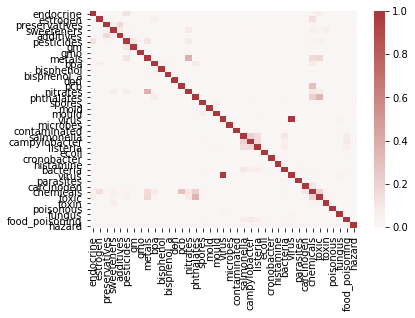

In [13]:
sns.heatmap(countdf[make_underscores(h)].corr().dropna(axis=0, how='all').dropna(axis=1,how='all'), \
            cmap= "vlag", center=0.00, xticklabels=True, yticklabels=True)

In [14]:
summed_df = pd.DataFrame()

for key in products.keys():
    summed_df[key] = countdf[make_underscores(products[key])].sum(axis=1)
for key in hazards.keys():
    summed_df[key] = countdf[make_underscores(hazards[key])].sum(axis=1)
for key in extras.keys():
    summed_df[key] = countdf[make_underscores(extras[key])].sum(axis=1)

### process the fruit, vegetable, baby columns

Idea: we only want to count mentions of fruit in the context of baby food. So we take the count of fruit and multiply it by the whether the mentions of baby are non-zero or not.

In [15]:
#count mentions of fruit or vegetable
#return 0 if there is no words indicating a context of BABY foods (not adult foods)
#note that baby food brand names occur much more than fruit or veg. Am not sure if they co-occur.
#TODO: maybe it is better to add the brands in with the fruit / veg. But since it is highly corr with them alreayd, at least looking by post it isnt a problem
summed_df['fruit_in_baby_context'] = summed_df['fruit']  * (summed_df[['baby_food_brands', 'food_or_formula_brands', 'baby']].sum(axis=1) > 0)
summed_df['veg_in_baby_context'] = summed_df['vegetable']  * (summed_df[['baby_food_brands', 'food_or_formula_brands', 'baby']].sum(axis=1) > 0)

#if there is mention of fruit or vegetable it's not uncategorized. return 0
# if no mentions, sum the counts of mentions of baby food brands
# possible improvement: check for words indicating a food, or in weaning forum etc. THEN we can also add food_or_formula_brands to the COUNT.
summed_df['baby_food_uncategorized'] = (summed_df[['fruit','vegetable']].sum(axis=1) > 0) * summed_df['baby_food_brands']

In [16]:
class_df = summed_df.copy()

In [17]:
product_cols = list(products.keys()) + ['veg_in_baby_context', 'fruit_in_baby_context', 'baby_food_uncategorized']

In [18]:
#classify
class_df['product_type'] = class_df[product_cols].idxmax(axis=1)
# idxmax has a strange behavior where it will set all-zero sets to an arbitrary category (the first one available?)
# so we must manually change them to an NA category.
class_df.loc[class_df[product_cols].max(axis=1) == 0,'product_type'] = 'NA'
# convert to categorical (factors)
class_df['product_type'] = class_df['product_type'].astype('category')

# Check the Resulting Totals

## Total Count

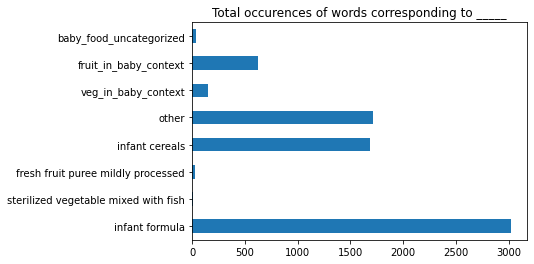

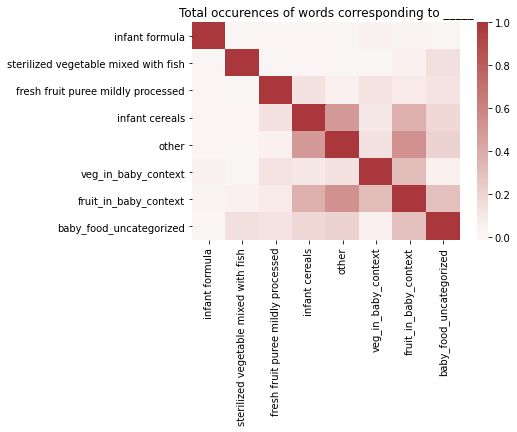

In [19]:
class_df[product_cols].sum(axis=0).plot(kind='barh')
plt.title('Total occurences of words corresponding to _____')
plt.show()
sns.heatmap(class_df[product_cols].corr(), cmap= "vlag", center=0.00)
plt.title('Total occurences of words corresponding to _____')
plt.show()

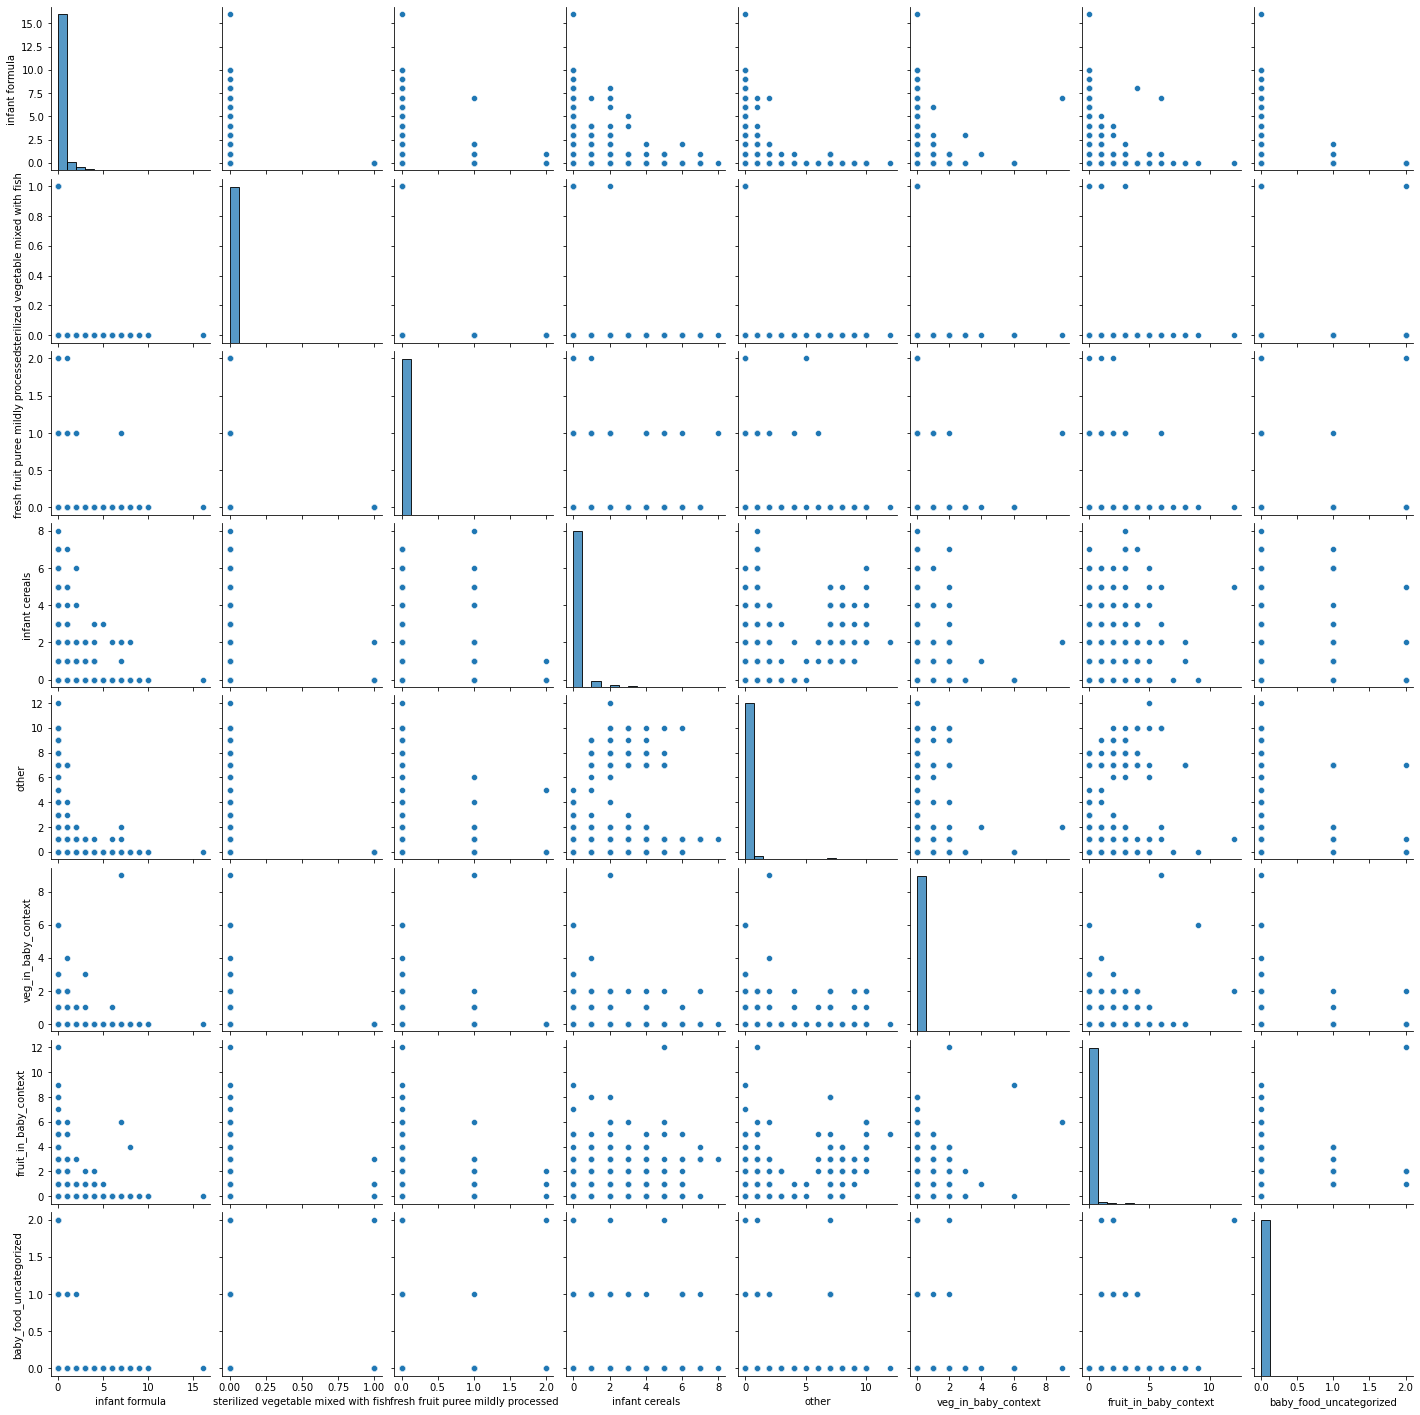

In [20]:
sns.pairplot(class_df[product_cols])

## Number of Posts Containing an Occurence

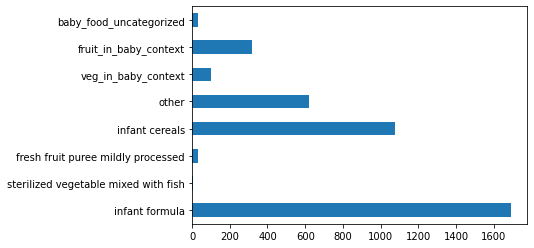

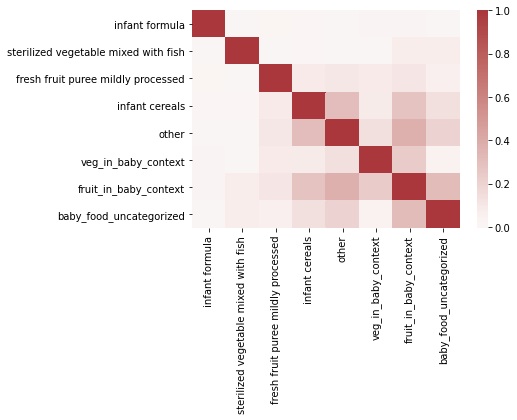

In [21]:
(class_df[product_cols] > 0).sum(axis=0).plot(kind='barh')
plt.show()
sns.heatmap((class_df[product_cols] > 0).corr(), cmap= "vlag", center=0.00)
plt.show()

# Check the Classification

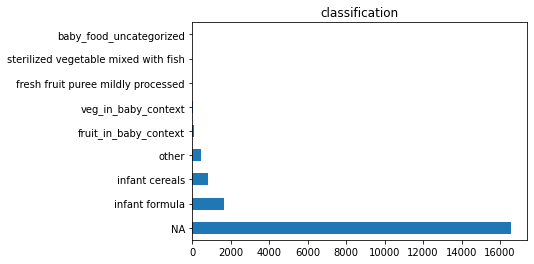

<AxesSubplot:title={'center':'classification (log scale)'}>

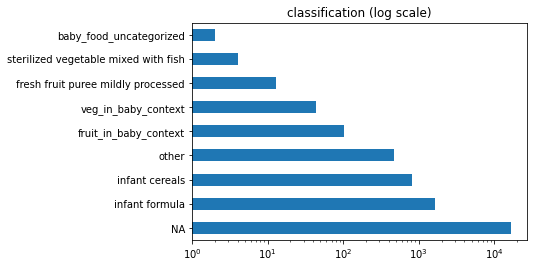

In [22]:
class_df['product_type'].value_counts().plot.barh(title = 'classification')
plt.show()

class_df['product_type'].value_counts().plot.barh(title='classification'+ ' (log scale)', log=True)

# Hazard Occurences by Product Class

## Number of Occurences

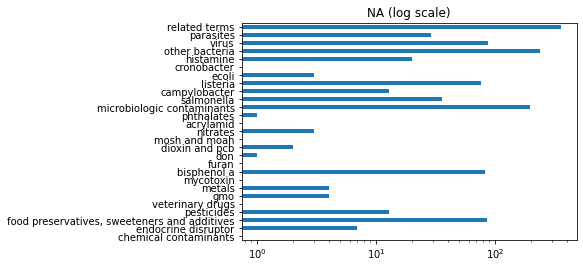

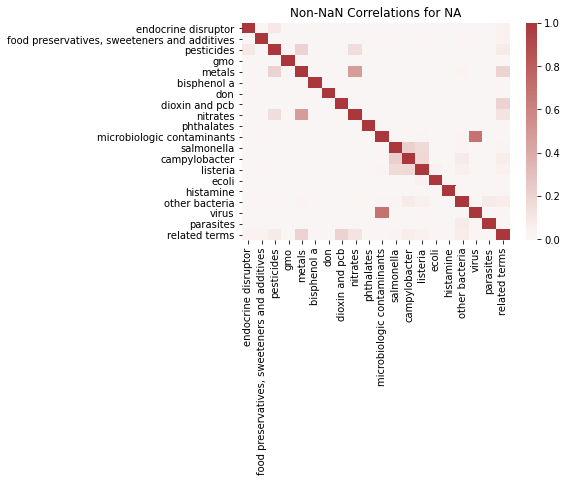

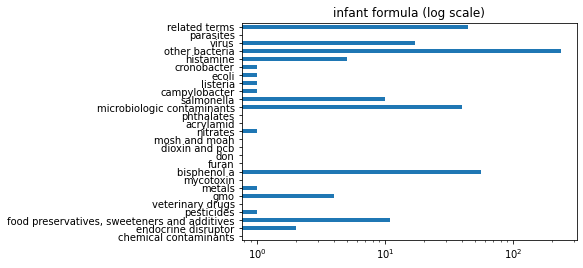

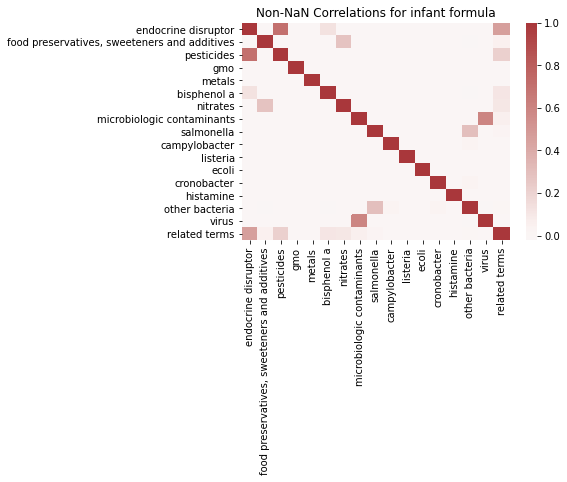

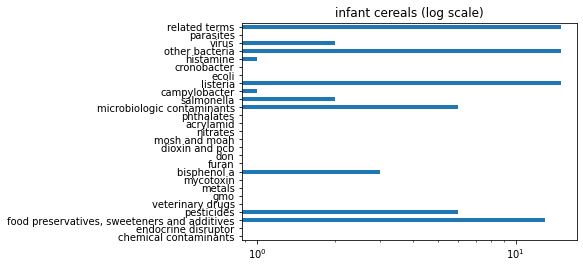

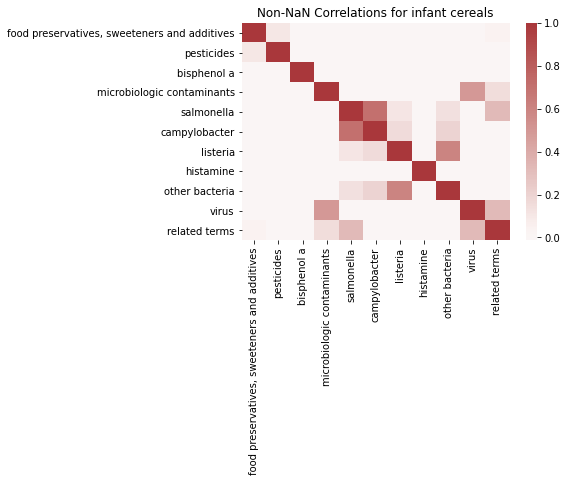

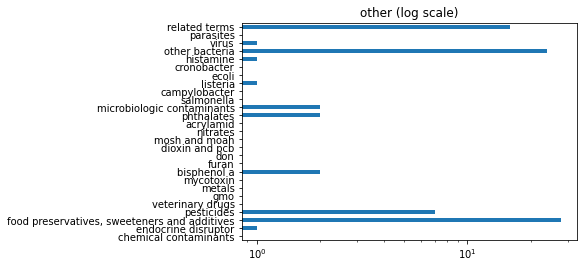

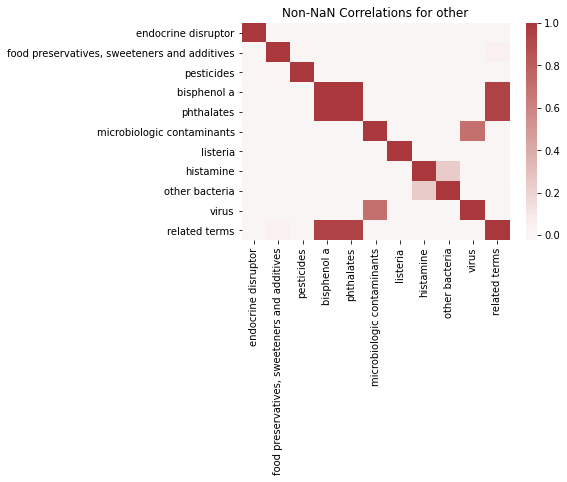

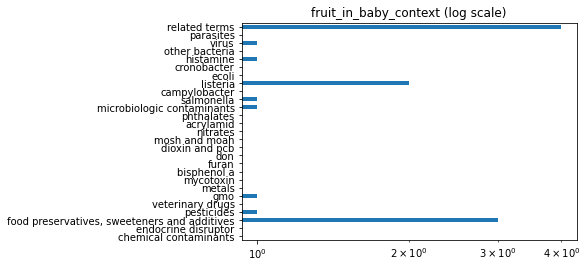

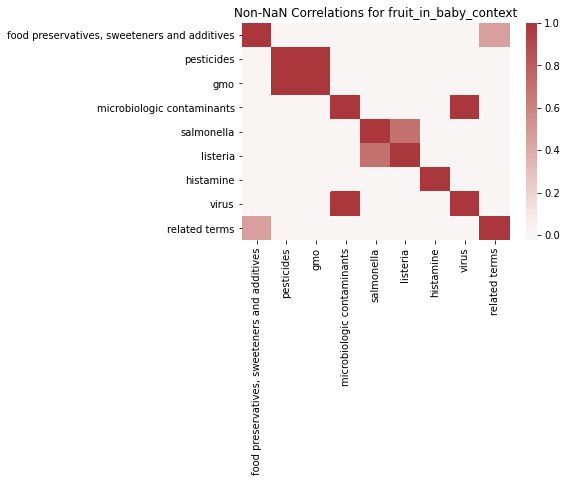

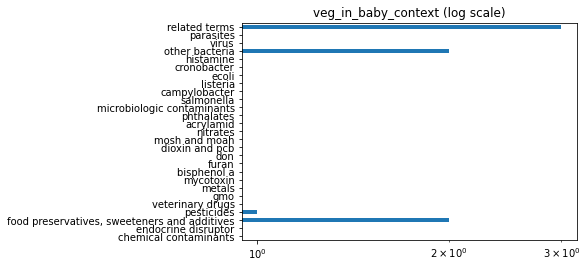

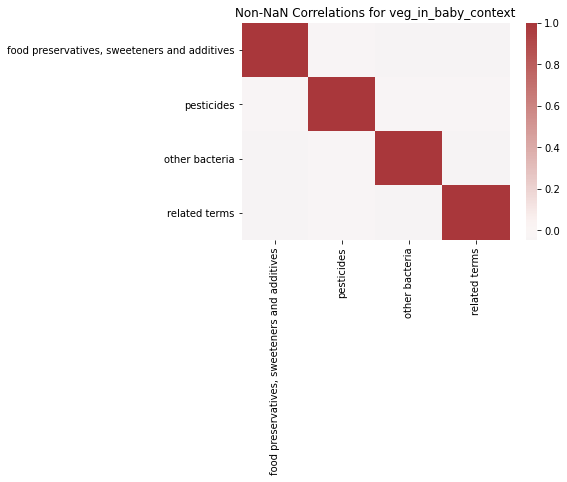

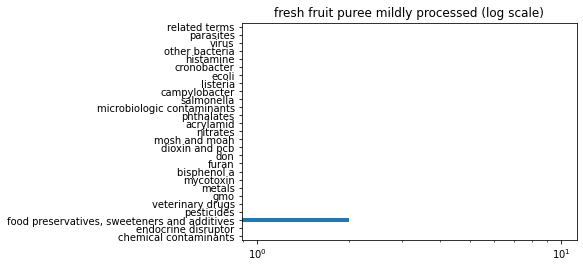

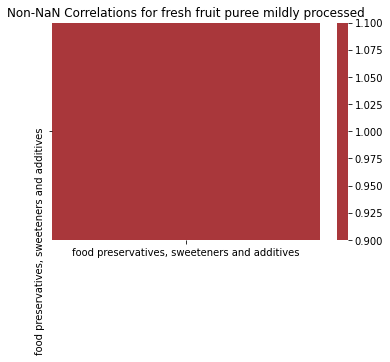

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:532: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  labels = axis.get_majorticklabels() + axis.get_minorticklabels()


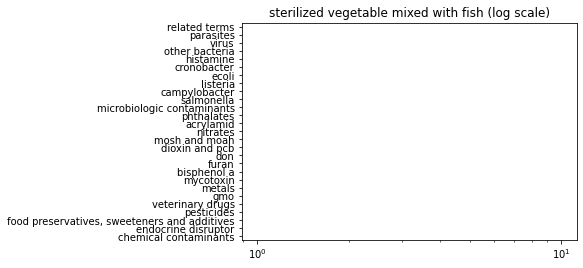

[insufficient data to render sterilized vegetable mixed with fish plot! ]


/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:532: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  labels = axis.get_majorticklabels() + axis.get_minorticklabels()


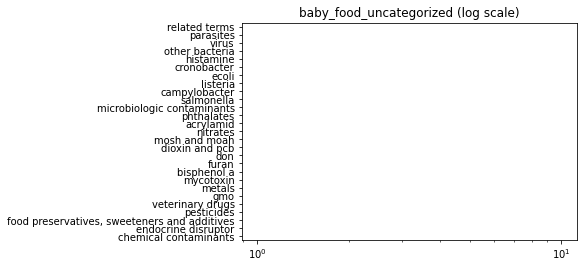

[insufficient data to render baby_food_uncategorized plot! ]


In [23]:
for category in list(class_df['product_type'].value_counts().index): #get the non-zero labels (zero labels may create an error)
    try:
        class_df.loc[class_df.product_type == category][hazards.keys()].sum(axis=0).plot.barh(title=category+ ' (log scale)', log=True)
        plt.show()
    except ValueError:
        print('[insufficient data to render %s plot! ]' % (category))
        
    non_nan_correlation = class_df.loc[class_df.product_type == category][hazards.keys()].corr().dropna(axis=1, how='all').dropna(axis=0, how='all')
    try:
        sns.heatmap(non_nan_correlation, cmap= "vlag", center=0.00, xticklabels=True, yticklabels=True)
        plt.title('Non-NaN Correlations for ' + str(category))
        plt.show()
    except ValueError:
        print('[insufficient data to render %s plot! ]' % (category))

## Number of Posts Containing and Occurence

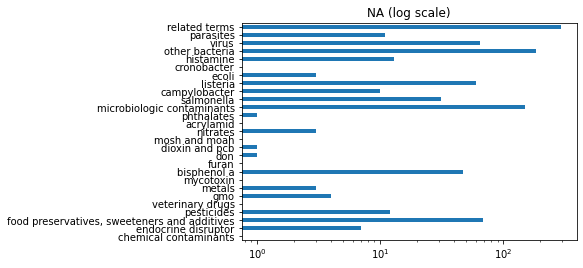

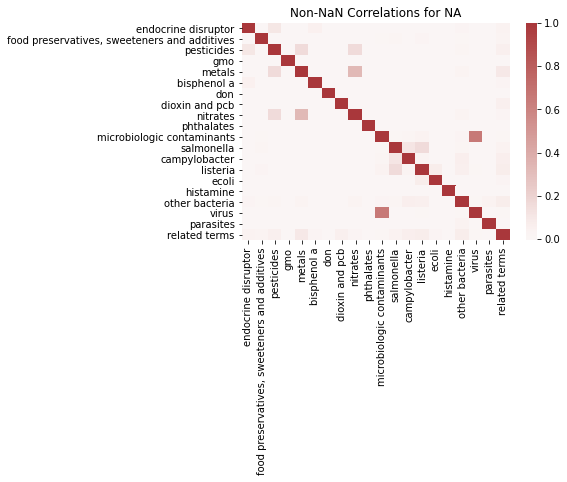

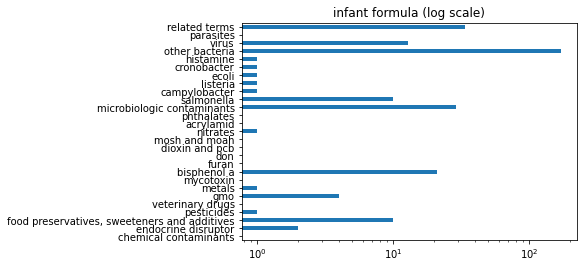

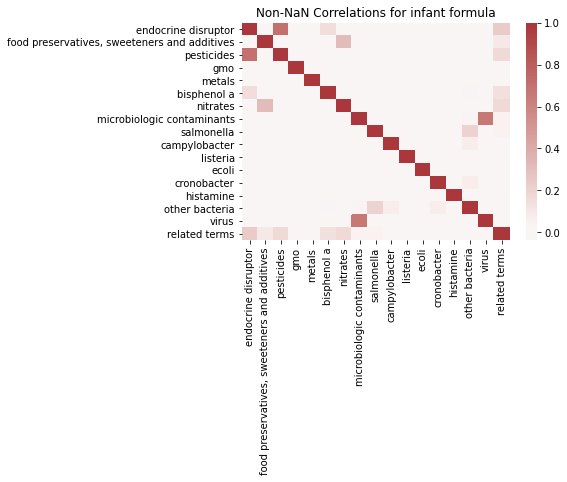

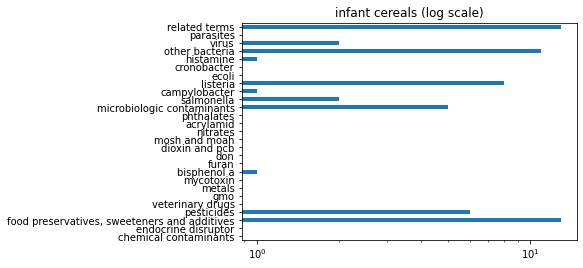

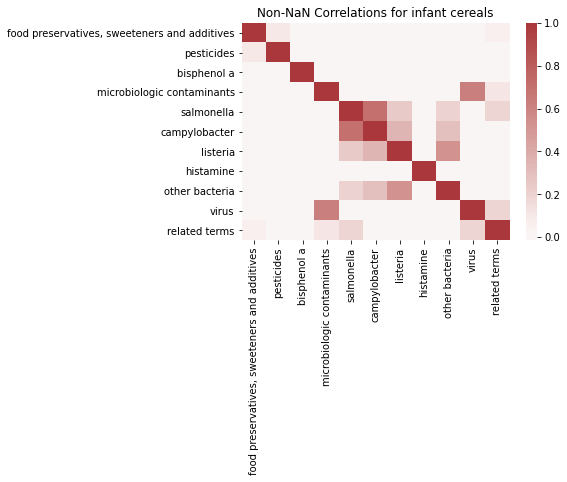

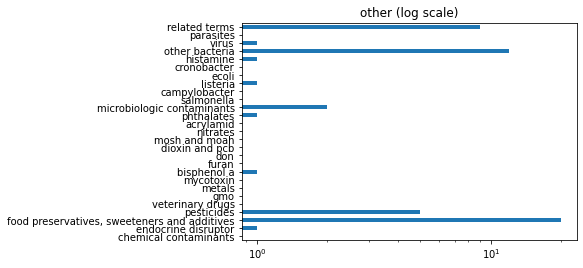

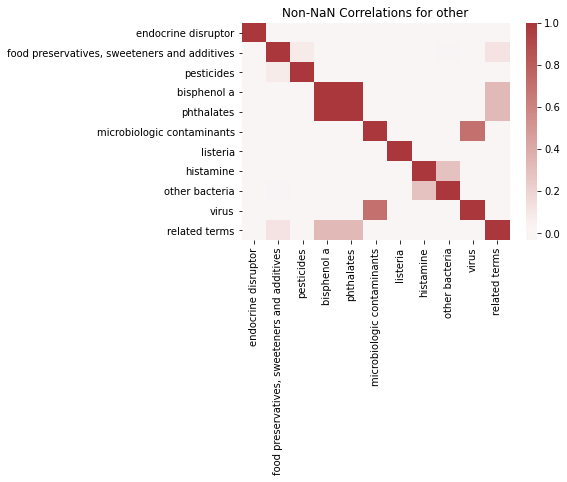

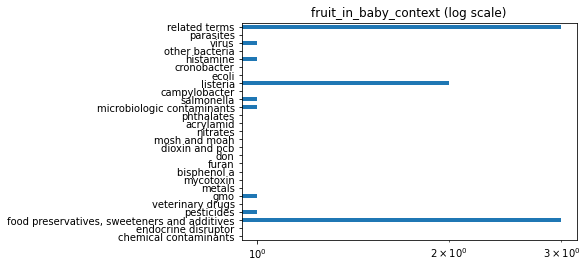

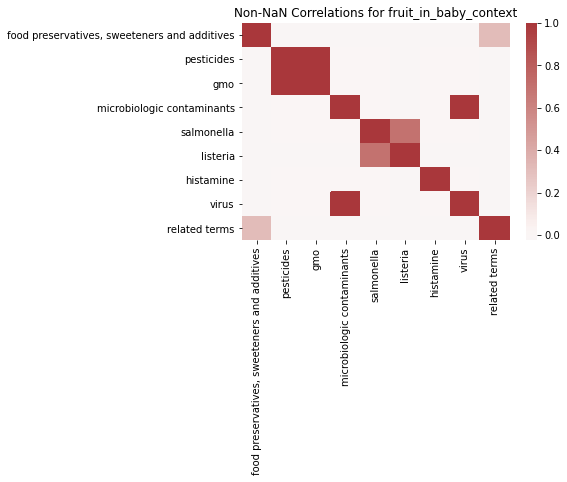

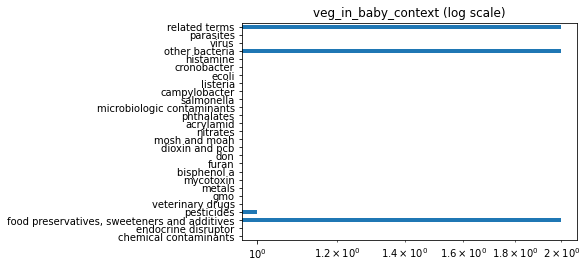

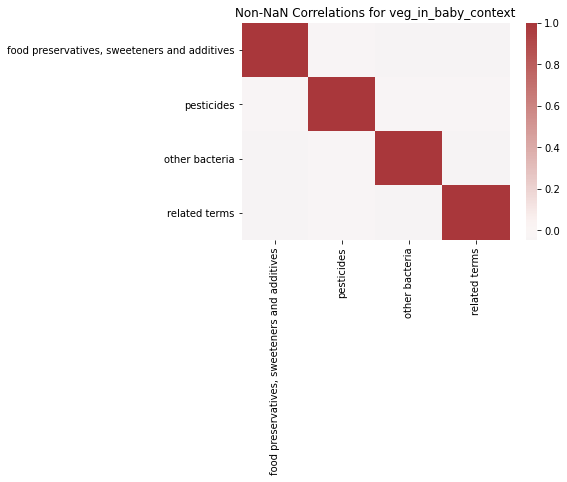

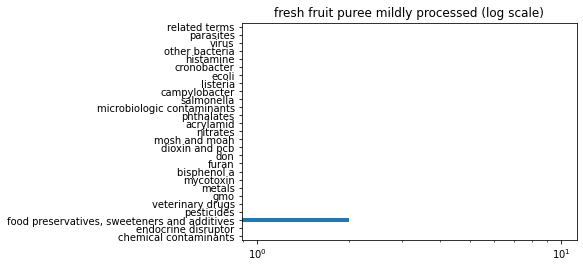

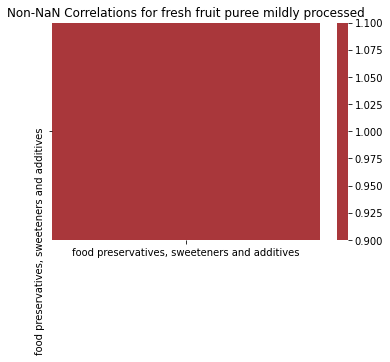

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:532: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  labels = axis.get_majorticklabels() + axis.get_minorticklabels()


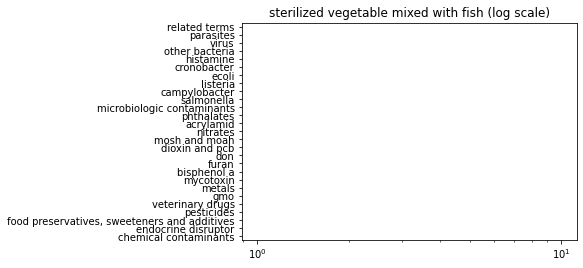

[insufficient data to render sterilized vegetable mixed with fish plot! ]


/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:532: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  labels = axis.get_majorticklabels() + axis.get_minorticklabels()


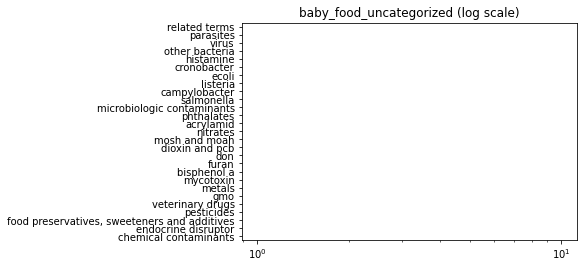

[insufficient data to render baby_food_uncategorized plot! ]


In [24]:
for category in list(class_df['product_type'].value_counts().index): #get the non-zero labels (zero labels may create an error)
    num_of_posts = class_df.loc[class_df.product_type == category][hazards.keys()] > 0
    
    try:
        num_of_posts.sum(axis=0).plot.barh(title=category+ ' (log scale)', log=True)
        plt.show()
    except ValueError:
        print('[insufficient data to render %s plot! ]' % (category))
        
    non_nan_correlation = num_of_posts.corr().dropna(axis=1, how='all').dropna(axis=0, how='all')
    try:
        sns.heatmap(non_nan_correlation, cmap="vlag", center=0.00,xticklabels=True, yticklabels=True)

        plt.title('Non-NaN Correlations for ' + str(category))
        plt.show()
    except ValueError:
        print('[insufficient data to render %s plot! ]' % (category))

# Count of Users Mentioning Each set of Words  (OR SOMETHING??) (TODO)

In [25]:
#formula_classed = term_count_product_df.loc[term_count_product_df.labels == 'term_counts_formula'].index

In [26]:
#term_count_hazard_df.loc[term_count_product_df.labels == 'term_counts_formula'].sum(axis=0).plot.barh(figsize=(4,10))

In [27]:
#temp[0]

In [28]:
#DEBUGGING DON
temp = list(class_df[class_df.don > 0].index)
posts_dict[temp[0]]


{'username': 'Anonymous',
 'likes': '0',
 'date': '4/16/2012 at 11:04 PM',
 'quotes_y': [{'text': "hi, i bottle fed my baby from 1 month old and every evening i would boil the kettle and fill all the bottles i would need over the next 24 hours. i would make sure they were sealed properly with the disc and lid on firmly, then as the it creates a vacuum stopping any bugs getting in. then i just added the formula as and when my baby wanted a feed. my little one was also happy to have it at room temperature so i never had to warm them up. i never had any issues at all. it wasn't too long ago that they said make up the full feed in advance and keep them in the fridge so i have no idea why they insist you do them one at a time half an hour in advance etc, it is just not practical. if the bottles are sterilised then have boiling water put in them then they should be fine. hope that helps. ",
   'name': 'Anonymous'}],
 'quotes_w': [],
 'body': 'this is what i did and was advised by the hv to d

In [29]:
len(temp)

1

# Running KNN on the processed numbers. (maybe) TODO 

# LDA Approach...

 how many possible cateorgires do we have?
 4 Products
 18 Hazards

 so we do
     * k = 4
     * k = 18
     * k = $18*4$ = 72


In [30]:
#TODO: 
#we can try this approach at the post level and comment level.
# (IN ANOTHER JUPYTER NOTEBOOK)


#  Feature Extraction: Sentiment Analysis

## NLTK Vader Sentiment Analysis
https://www.nltk.org/howto/sentiment.html


* calculate sentiment for each post
* save it into dataframe.

The VADER algorithm outputs sentiment scores to 4 classes of sentiments https://github.com/nltk/nltk/blob/develop/nltk/sentiment/vader.py#L441:

* neg, neu, pos - ratios for proportions of text that fall in each category (negative, neutral, positive)
    * neg + neu + pos = 1
    * in [0,1]
    * IMPORTANTLY: these proportions represent the "raw categorization" of each lexical item (e.g., words, emoticons/emojis, or initialisms) into positve, negative, or neutral classes; they do not account for the VADER rule-based enhancements such as word-order sensitivity for sentiment-laden multi-word phrases, degree modifiers, word-shape amplifiers, punctuation amplifiers, negation polarity switches, or contrastive conjunction sensitivity.
* compound - composite score, with added VADER weightings and rules, and normalized
    * in [-1,1]

more details: https://github.com/cjhutto/vaderSentiment#about-the-scoring

In [31]:
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

In [32]:
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /Users/sma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sma/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [33]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#initialize object
sid = SentimentIntensityAnalyzer()

In [34]:
def nltk_sentiments(text):
    """
    Split sentences, parse and get modality of sentences, then return the mean of the modalities. (or something, #TODO)
    We need to split sentences because sentence structure is parsed. In sentiment anal it uses bag of words instead #TODO: verify this. I know nltk uses bag of words
    """
    sentences = tokenize.sent_tokenize(text)
    #remove sentences which have no alphabet data, they will bias our results.
    #this could also remove emoticons but oh well.
    #TODO: add THE SAME cleaning into the patterns one.
    #TODO: add code to remove sentences which only contain the letter X (there is a LOT of these on netmums tbh.)
    sentences = [sentence for sentence in sentences if sentence.upper().isupper()]
    sentiments = [sid.polarity_scores(sentence) for sentence in sentences]
    try:
        sentiment_keys = list(sentiments[0].keys())
        means = {sentiment_keys[ind]: np.mean(nums) for ind,nums in enumerate(list(zip(*[list(i.values()) for i in sentiments])))}
        variances = {sentiment_keys[ind]: np.var(nums) for ind,nums in enumerate(list(zip(*[list(i.values()) for i in sentiments])))}
        return means, variances
    except IndexError:
        sad_dict = {'neg':None, 'neu': None, 'pos':None, 'compound':None}
        return sad_dict, sad_dict
        

In [35]:
#run it
start = time.time()
temp = [(key, nltk_sentiments(posts_dict[key]['body'])) for key in class_df.index]

keys, sentiments_by_sentence = zip(*temp)
end = time.time()


#the tuple contains [0]:mean, [1]:var, we assign 
#the means of each feature and the vars of each feature
#to a new columns in the dataframe.

class_df['nltk_neg_mean'], class_df['nltk_neg_var'] =  \
        pd.Series([i[0].get('neg') for i in sentiments_by_sentence], index=keys), \
            pd.Series([i[1].get('neg') for i in sentiments_by_sentence], index=keys)

class_df['nltk_neu_mean'], class_df['nltk_neu_var'] =  \
        pd.Series([i[0].get('neu') for i in sentiments_by_sentence], index=keys), \
            pd.Series([i[1].get('neu') for i in sentiments_by_sentence], index=keys)

class_df['nltk_pos_mean'], class_df['nltk_pos_var'] =  \
        pd.Series([i[0].get('pos') for i in sentiments_by_sentence], index=keys), \
            pd.Series([i[1].get('pos') for i in sentiments_by_sentence], index=keys)

class_df['nltk_compound_mean'], class_df['nltk_compound_var'] =  \
        pd.Series([i[0].get('compound') for i in sentiments_by_sentence], index=keys), \
            pd.Series([i[1].get('compound') for i in sentiments_by_sentence], index=keys)

print(end-start)

39.11712169647217


## Patterns Measures
https://github.com/clips/pattern/wiki/pattern-en#sentiment
https://github.com/clips/pattern/wiki/pattern-en#mood--modality

* Sentiment - from -1 to 1
* Objectivity/Subjectivity - from 0 to 1
* Modality - from -1 to 1

mood simply has a grammar detection system and returns the first mood signalled by grammar that is detected in a sentence.

modality - "Epistemic modality" is used to express possibility (i.e. how truthful is what is being said).

 The modality() function was tested with BioScope and Wikipedia training data from CoNLL2010 Shared Task 1.
 See for example Morante, R., Van Asch, V., Daelemans, W. (2010):
 Memory-Based Resolution of In-Sentence Scopes of Hedge Cues
 http://www.aclweb.org/anthology/W/W10/W10-3006.pdf
 Sentences in the training corpus are labelled as "certain" or "uncertain".
 For Wikipedia sentences, 2000 "certain" and 2000 "uncertain":
 modality(sentence) > 0.5 => A 0.70 P 0.73 R 0.64 F1 0.68

In [36]:
from pattern.en import sentiment

In [37]:
#debug
sentiment([i for i in posts_dict.values()][0]['body'])

(0.1266666666666667, 0.6666666666666667)

In [38]:
#illustrate how we can check individual word values with pattern.
sentiment([i for i in posts_dict.values()][0]['body']).assessments

[(['easy'], 0.43333333333333335, 0.8333333333333334, None),
 (['huge'], 0.4000000000000001, 0.9, None),
 (["n't", 'fit'], -0.2, 0.4, None),
 ([':/'], -0.25, 1.0, 'mood'),
 (['thanks', '!'], 0.25, 0.2, None)]

In [39]:
#debug
[i for i in posts_dict.values()][0]['body']

"mam bottles hi everyone! looking for anyone that uses these or is planning on it. are they easy to use? what steriliser are you using? have heard the mam microwave one is huge, worried it won't fit : /\n thanks! "

In [40]:
#debug
temp = [sentiment(posts_dict[key]['body']) for key in class_df.index]

In [41]:
#calculate sentiments using pattern
keys, sent_and_subj = zip(*[(key, sentiment(posts_dict[key]['body'])) for key in class_df.index])
subj, sent = zip(*sent_and_subj)
del sent_and_subj
#save it to dataframe.
class_df['sentiment'], class_df['subjectivity'] =  pd.Series(sent, index=keys), pd.Series(subj, index=keys)

In [42]:
from pattern.en import parse, Sentence
from pattern.en import modality, mood

In [43]:
#The current version (3.6) of pattern has been unmaintained and the fix for this has not been implemented.
#This is a hacky method of getting around the error
#I suggest that you modify the pattern package yourself as described here (https://github.com/clips/pattern/issues/308)

#This hacky fix is included in order to maintain compatibility for those who have just installed the package.
#
# If you ever get RuntimeError, just try to rerun that cell until it doesnt give an error and then the rest from there.

i = 0
j = 0
while i == 0: #WORKAROUND
    j += 1
    try:
        modality(Sentence(parse('''Please stop giving me StopIteration Error!''')))
        if j > 4:
            i += 1
        print('pattern.en said ok.')
    except RuntimeError:
        print('pattern.en said no.')
        pass

pattern.en said no.
pattern.en said no.
pattern.en said ok.
pattern.en said ok.
pattern.en said ok.


In [44]:
def split_sentences(text):
    sentence_separators = re.findall('[\n?!.]+', text) + ['']
    sentences = re.split('[\n?!.]+', text)
    for ind, _ in enumerate(sentence_separators): #we keep the punctuation which sep sentences bc question marks are used in modality calculation.
        sentences[ind] += sentence_separators[ind]
    return sentences

def parse_and_get_m(text, get_mood=False, get_modal=True):
    """
    Split sentences, parse and get modality of sentences, then return the mean of the modalities. (or something, #TODO)
    We need to split sentences because sentence structure is parsed. In sentiment anal it uses bag of words instead #TODO: verify this. I know nltk uses bag of words
    """
    sents= [Sentence(parse(s, lemmata=True)) for s in split_sentences(text)] #I don't think the punctuations are used in modality or mood detection.
    ## Debug note: i forgot to parse and convert to Sentence object, but it ran fine (same results too).
    ## But now on re-running and debugging due to an error mentioned above,
    ## it seems that it is slow, regardless if I parse sentences myself or not.
    if get_mood:
        if get_modal:
            return [(modality(s), mood(s)) for s in sents]
        else:
            return [ mood(s) for s in sents]
    elif get_modal:
        return [modality(s) for s in sents]
    else:
        return None
        

In [45]:
#run it
start = time.time()
try: #ANOTHER WORKAROUND for this package. It needs to be run twice. No idea why.
    temp = [(key, parse_and_get_m(posts_dict[key]['body'])) for key in class_df.index]
except:
    temp = [(key, parse_and_get_m(posts_dict[key]['body'])) for key in class_df.index]
keys, modalities_by_sentence = zip(*temp)
end = time.time()
%notify

#prepare datatypes and add to dataframe
mean, var = zip(*[(np.mean(x), np.var(x)) for x in modalities_by_sentence])
del modalities_by_sentence

class_df['modality_sentence_mean'], class_df['modality_sentence_var'] =  pd.Series(mean, index=keys), pd.Series(var, index=keys)

<IPython.core.display.Javascript object>

In [46]:
#code to generate colors for denisty of points of scatter plot.

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde as kde
from matplotlib.colors import Normalize
from matplotlib import cm
#source: https://stackoverflow.com/questions/19064772/visualization-of-scatter-plots-with-overlapping-points-in-matplotlib

def makeColours( vals ):
    colours = np.zeros( (len(vals),3) )
    norm = Normalize( vmin=vals.min(), vmax=vals.max() )

    #Can put any colormap you like here.
    colours = [cm.ScalarMappable( norm=norm, cmap='jet').to_rgba( val ) for val in vals]

    return colours

def get_cols_and_array_from_df(df, first_col:str,second_col:str):
    #we need to use a np array for kde, and make sure its the correct shape
    sample = np.array(list((zip(*np.array(df[[first_col,second_col]])))))

    #calculate densities per point
    densObj = kde(np.array(list((zip(*np.array(df[[first_col,second_col]]))))))
    # generate colormap
    colours = makeColours( densObj.evaluate( sample ) )
    return sample, colours

def heat_scatter(df, first_col:str, second_col:str, point_size=2):
    try:
        sample, colours = get_cols_and_array_from_df(df, first_col, second_col)
    except ValueError: # if there are NAs remove them
        sample, colours = get_cols_and_array_from_df(class_df.dropna(axis=0, subset=[first_col, second_col]), \
                                                     first_col, second_col)
    plt.scatter(y=sample[0],x=sample[1], color=colours, s=point_size)
    plt.xlabel(second_col)
    plt.ylabel(first_col)
        

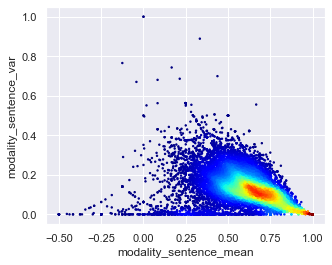

In [47]:
sns.set(rc={'figure.figsize':(5,4)})
heat_scatter(class_df, 'modality_sentence_var','modality_sentence_mean')

## Most Relevant Metrics
pattern_sentiment, pattern_subjectivity, nltk_sentiment

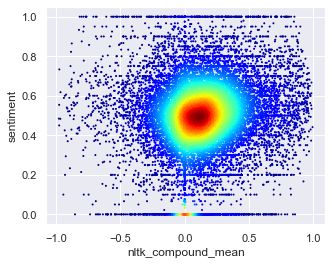

In [48]:
heat_scatter(class_df, 'sentiment','nltk_compound_mean', point_size=1)

<AxesSubplot:xlabel='nltk_compound_mean', ylabel='sentiment'>

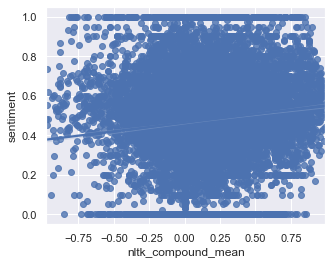

In [49]:
sns.regplot(y= 'sentiment', x ='nltk_compound_mean', data=class_df)

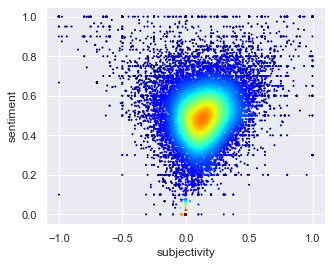

In [50]:
heat_scatter(class_df, 'sentiment','subjectivity', point_size=1)

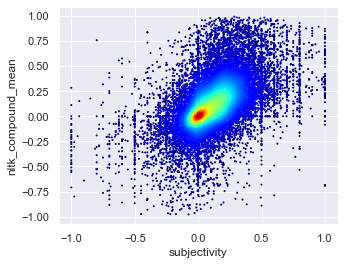

In [51]:
heat_scatter(class_df,'nltk_compound_mean','subjectivity', point_size=1)

## Other stuff

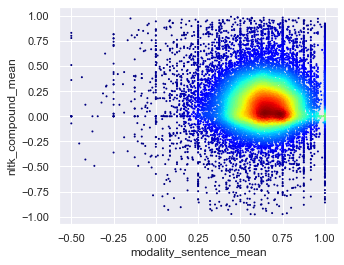

In [52]:
heat_scatter(class_df,'nltk_compound_mean','modality_sentence_mean', point_size=1)

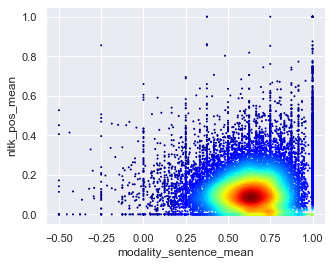

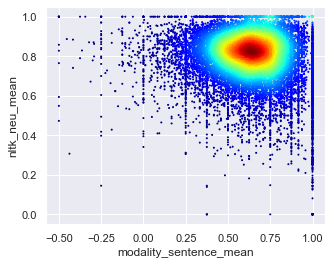

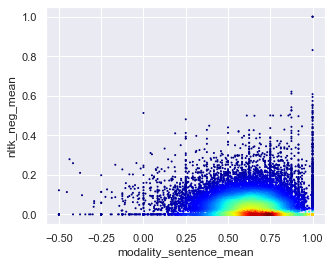

In [53]:
heat_scatter(class_df,'nltk_pos_mean','modality_sentence_mean', point_size=1)
plt.show()
heat_scatter(class_df,'nltk_neu_mean','modality_sentence_mean', point_size=1)
plt.show()
heat_scatter(class_df,'nltk_neg_mean','modality_sentence_mean', point_size=1)
plt.show()

In [54]:
pattern_all = ['sentiment','subjectivity','modality_sentence_mean','modality_sentence_var']
nltk_means = ['nltk_neg_mean','nltk_neu_mean', 'nltk_pos_mean', 'nltk_compound_mean' ]  
nltk_vars = ['nltk_neg_var','nltk_neu_var','nltk_pos_var','nltk_compound_var']

<AxesSubplot:>

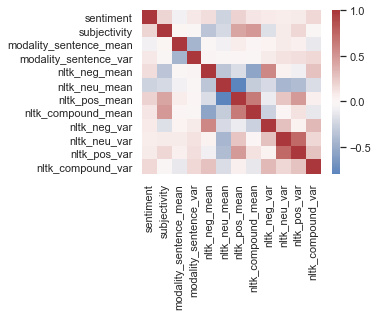

In [55]:
sns.set(rc={'figure.figsize':(4,3)})
sns.heatmap(class_df[pattern_all + nltk_means + nltk_vars].corr(), \
            cmap= "vlag", center=0.00, xticklabels=True, yticklabels=True)

Negative correlations between nltk pos, neu, neg is expected since sum(...) = 1

Correlations with nltk compound reveal the relationship after VADER rules are applied.

Pattern sentiment and ntlk compound are positively correlated which is good, these two scores generally agree.

Subjectivity and Modality are not highly correlated with either, overall. But subjectivity has small (~0.25) negative correlation with neutrality. This is quite intuitive as posts with less strongly indicative words will have more neutral sentiment as well as register a more objective

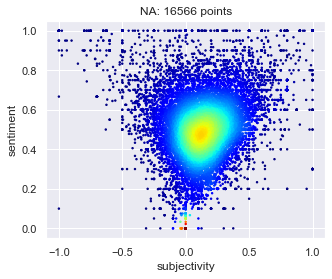

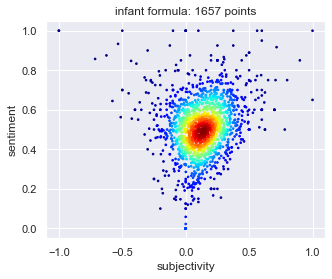

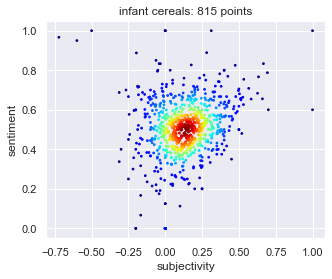

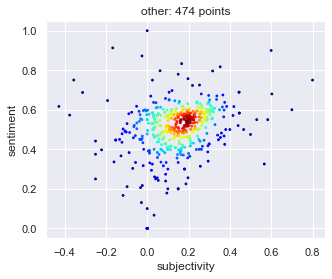

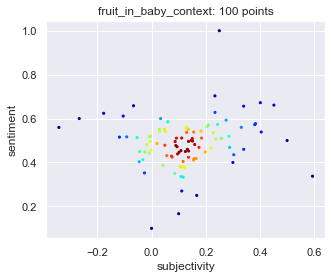

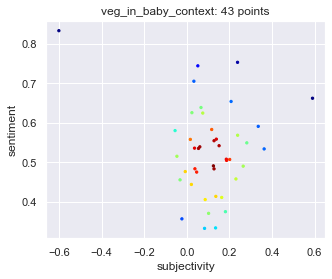

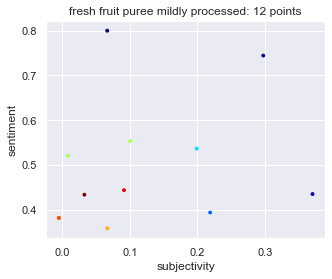

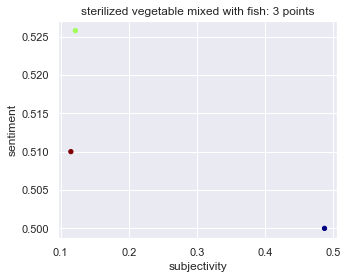

<ipython-input-56-62a519672f6b>:6: RuntimeWarning: divide by zero encountered in double_scalars
  size_for_cat = 20./np.log(len(num_of_posts)) #make points bigger when theres less data to show.
/usr/local/lib/python3.8/site-packages/scipy/stats/kde.py:574: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


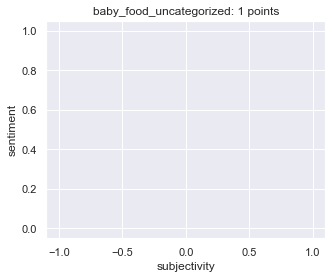

In [56]:
sns.set(rc={'figure.figsize':(5,4)})
errs = []
for category in list(class_df['product_type'].value_counts().index): #get the non-zero labels (zero labels may create an error)
    try:
        num_of_posts = class_df.loc[class_df.product_type == category]
        size_for_cat = 20./np.log(len(num_of_posts)) #make points bigger when theres less data to show.
        heat_scatter(num_of_posts, 'sentiment','subjectivity', point_size=size_for_cat)
        plt.title(category + ': %s points' % len(num_of_posts))
        plt.show()
    except ValueError:
        print(category + ': insufficient data')
    except Exception as exc:
        errs.append(category + ' ' + str(exc))
        errs.append(str(traceback.format_exc()))
print('\n'.join(errs))

In [57]:
class_df.loc[np.abs(class_df['sentiment']) < 0.05].loc[class_df['subjectivity'] < 0.05]

infant formula  \
https://www.netmums.com/coffeehouse/becoming-mu... 16                0   
https://www.netmums.com/coffeehouse/becoming-mu... 3                 1   
https://www.netmums.com/coffeehouse/coffeehouse... 4                 0   
                                                   26                0   
                                                   29                0   
...                                                                ...   
https://www.netmums.com/coffeehouse/becoming-mu... 108               0   
https://www.netmums.com/coffeehouse/becoming-mu... 3                 0   
                                                   6                 0   
                                                   7                 0   
                                                   8                 0   

                                                        sterilized vegetable mixed with fish  \
https://www.netmums.com/coffeehouse/becoming-mu... 16                                      0   
https://www.netmums.com/coffeehouse/becoming-mu... 3                                       0   
https://www.netmums.com/coffeehouse/coffeehouse... 4                                       0   
                                                   26                                      0   
                                                   29                                      0   
...                                                                                      ...   
https://www.netmums.com/coffeehouse/becoming-mu... 108                                     0   
https://www.netmums.com/coffeehouse/becoming-mu... 3                                       0   
                                                   6                                       0   
                                                   7                                       0   
                                                   8                                       0   

                                                        fresh fruit puree mildly processed  \
https://www.netmums.com/coffeehouse/becoming-mu... 16                                    0   
https://www.netmums.com/coffeehouse/becoming-mu... 3                                     0   
https://www.netmums.com/coffeehouse/coffeehouse... 4                                     0   
                                                   26                                    0   
                                                   29                                    0   
...                                                                                    ...   
https://www.netmums.com/coffeehouse/becoming-mu... 108                                   0   
https://www.netmums.com/coffeehouse/becoming-mu... 3                                     0   
                                                   6                                     0   
                                                   7                                     0   
                                                   8                                     0   

                                                        infant cereals  other  \
https://www.netmums.com/coffeehouse/becoming-mu... 16                0      0   
https://www.netmums.com/coffeehouse/becoming-mu... 3                 1      0   
https://www.netmums.com/coffeehouse/coffeehouse... 4                 0      0   
                                                   26                0      0   
                                                   29                0      0   
...                                                                ...    ...   
https://www.netmums.com/coffeehouse/becoming-mu... 108               0      0   
https://www.netmums.com/coffeehouse/becoming-mu... 3                 0      0   
                                                   6                 0      0   
                                                   7                 0     

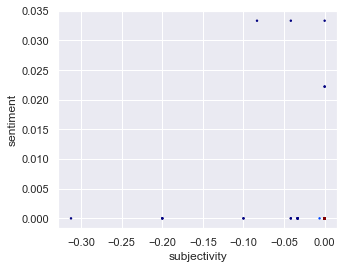

In [58]:
#display the outlier set, zoomed in!
heat_scatter(class_df.loc[np.abs(class_df['sentiment']) < 0.05].loc[class_df['subjectivity'] < 0.05], 'sentiment', 'subjectivity')

In [59]:
num_lower_sentiment = len(class_df.loc[class_df['sentiment'] < 0.1])
num_higher_sentiment = len(class_df.loc[class_df['sentiment'] >= 0.1])
print((num_lower_sentiment, num_higher_sentiment))

num_lower_subj = len(class_df.loc[class_df['subjectivity'] < 0.05])
num_higher_subj = len(class_df.loc[class_df['subjectivity'] >= 0.05])
print((num_lower_subj, num_higher_subj))

(1792, 17879)
(7432, 12239)


In [60]:
#TODO: save two lists of keys num_lower_subj, num_higher_subj

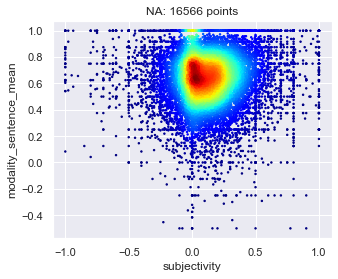

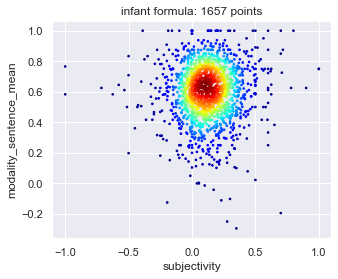

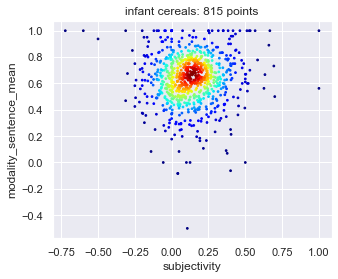

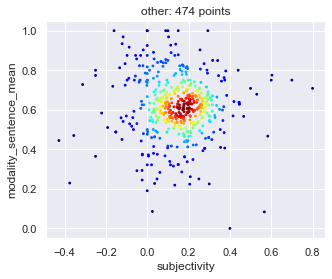

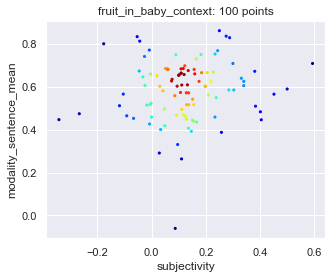

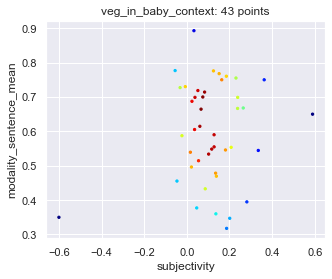

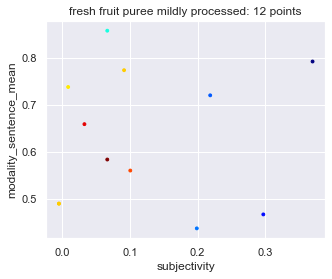

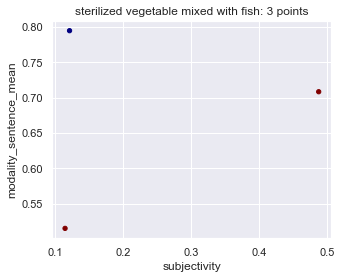

<ipython-input-61-0187a1e9abbf>:6: RuntimeWarning: divide by zero encountered in double_scalars
  size_for_cat = 20./np.log(len(num_of_posts)) #make points bigger when theres less data to show.
/usr/local/lib/python3.8/site-packages/scipy/stats/kde.py:574: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


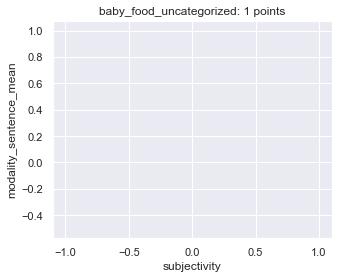

In [61]:
sns.set(rc={'figure.figsize':(5,4)})
errs = []
for category in list(class_df['product_type'].value_counts().index): #get the non-zero labels (zero labels may create an error)
    try:
        num_of_posts = class_df.loc[class_df.product_type == category]
        size_for_cat = 20./np.log(len(num_of_posts)) #make points bigger when theres less data to show.
        heat_scatter(num_of_posts, 'modality_sentence_mean','subjectivity', point_size=size_for_cat)
        plt.title(category + ': %s points' % len(num_of_posts))
        plt.show()
    except ValueError:
        print(category + ': insufficient data')
    except Exception as exc:
        errs.append(category + ' ' + str(exc))
        errs.append(str(traceback.format_exc()))
print('\n'.join(errs))

<ipython-input-64-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in log
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.


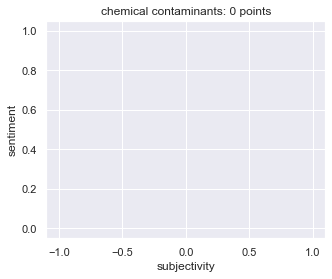

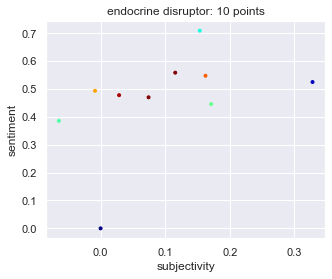

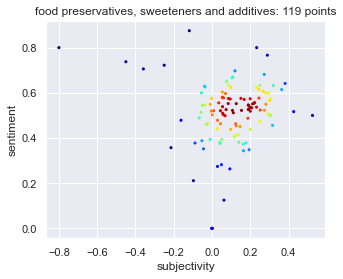

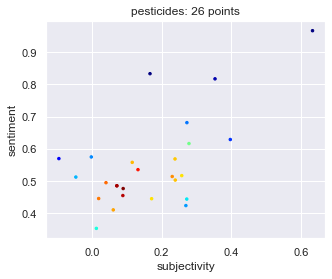

<ipython-input-64-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in log
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.


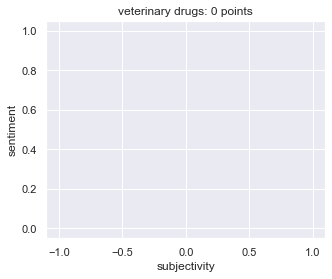

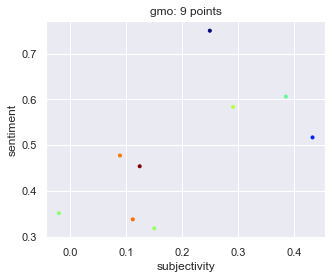

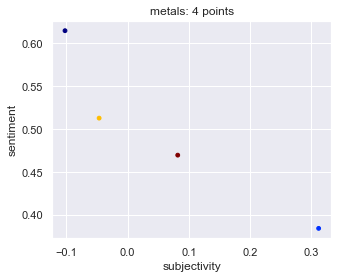

<ipython-input-64-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in log
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.


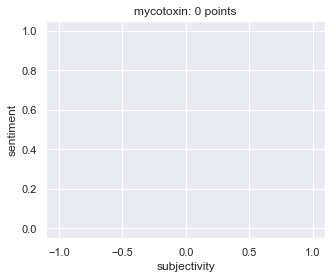

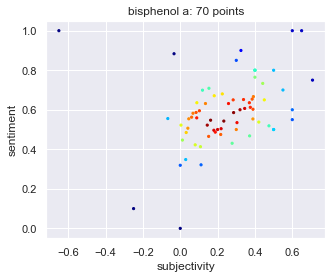

<ipython-input-64-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in log
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.


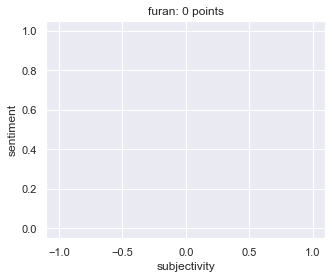

<ipython-input-64-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in double_scalars
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.
/usr/local/lib/python3.8/site-packages/scipy/stats/kde.py:574: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


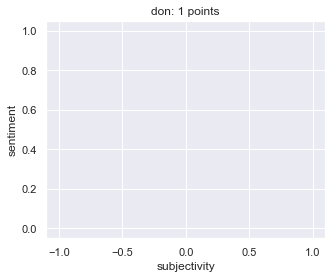

<ipython-input-64-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in double_scalars
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.
/usr/local/lib/python3.8/site-packages/scipy/stats/kde.py:574: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


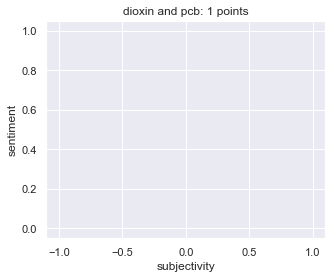

<ipython-input-64-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in log
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.


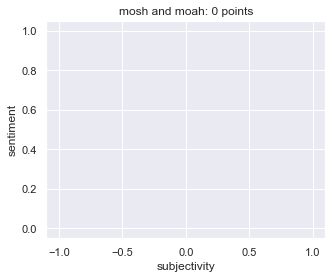

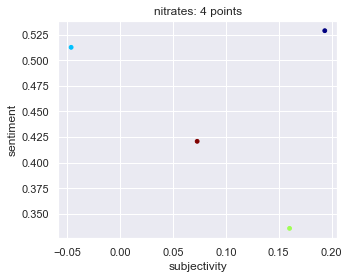

<ipython-input-64-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in log
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.


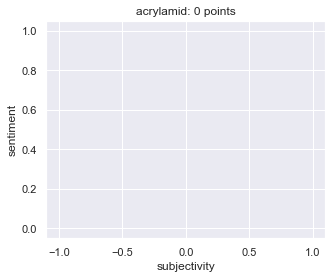

/usr/local/lib/python3.8/site-packages/scipy/stats/kde.py:263: RuntimeWarning: divide by zero encountered in true_divide
  result = result / self._norm_factor


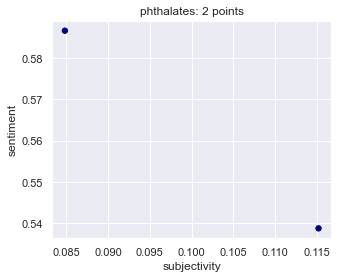

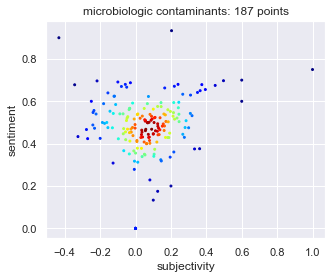

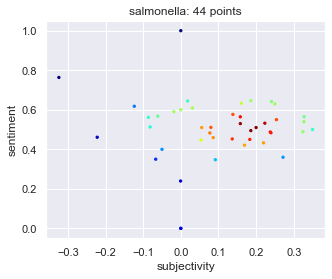

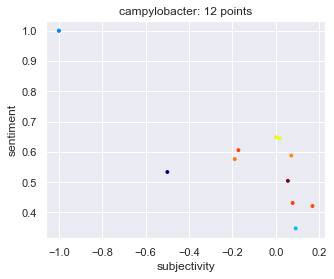

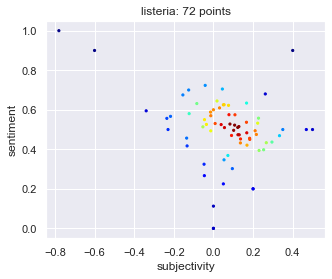

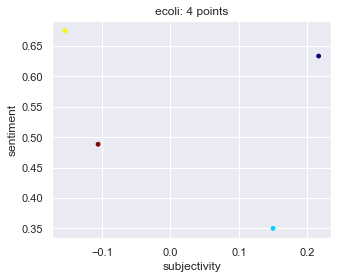

<ipython-input-64-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in double_scalars
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.
/usr/local/lib/python3.8/site-packages/scipy/stats/kde.py:574: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


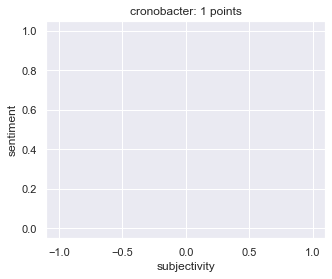

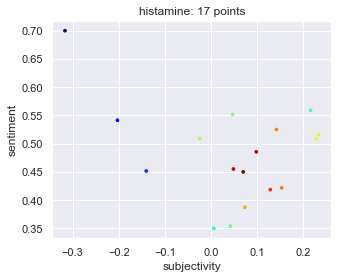

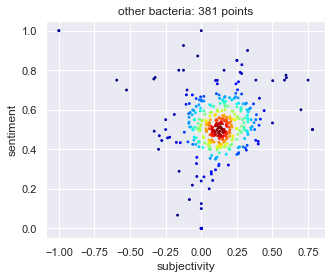

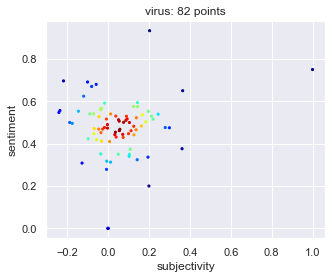

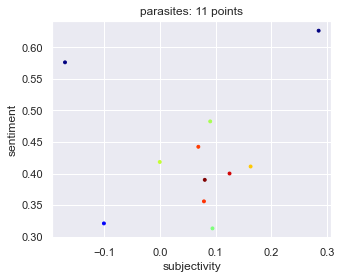

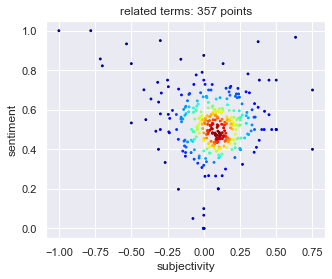

In [64]:
errs = []
for haz in hazards.keys():
    posts_for_hazard = class_df.loc[(class_df[haz] > 0)]
    try:
        size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.
        heat_scatter(posts_for_hazard, 'sentiment','subjectivity', point_size=size_for_cat)
        plt.title(haz + ': %s points' % len(posts_for_hazard))
        plt.show()
    except ValueError:
        print(haz + ': insufficient data')
    except Exception as exc:
        errs.append(haz + ' ' + str(exc))
        errs.append(str(traceback.format_exc()))
print('\n'.join(errs))

In [65]:
keys, modalities_by_sentence = zip(*[(key, parse_and_get_m(posts_dict[key]['body'])) for key in class_df.index])

temp=  pd.Series(modalities_by_sentence, index=keys)

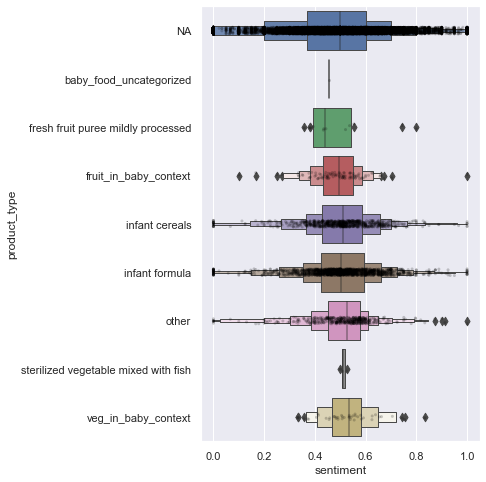

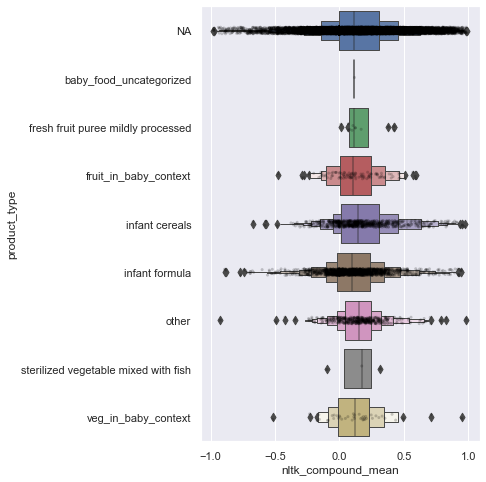

In [66]:
sns.set(rc={'figure.figsize':(5,8)})
sns.boxenplot(x='sentiment', y='product_type', data=class_df, k_depth = 'trustworthy' ) #most are sizes are quite large so it doesnt hurt to use this.
sns.stripplot(x='sentiment', y='product_type', data=class_df, color='black', alpha=0.2, jitter=0.07, size=3) #to give an idea of the sample size
plt.show()
sns.boxenplot(x='nltk_compound_mean', y='product_type', data=class_df, k_depth = 'trustworthy' ) #most are sizes are quite large so it doesnt hurt to use this.
sns.stripplot(x='nltk_compound_mean', y='product_type', data=class_df, color='black', alpha=0.2, jitter=0.07, size=3) #to give an idea of the sample size
plt.show()

#boxplot outlier detection:
#using a method that is a function of the inter-quartile range.
#https://seaborn.pydata.org/generated/seaborn.boxplot.html#seaborn.boxplot

In [67]:
#make classification for hazards and check it as well.
class_df['hazard_type'] = class_df[hazards.keys()].idxmax(axis=1)
class_df.loc[class_df[hazards.keys()].max(axis=1) == 0,'hazard_type'] = 'NA'
class_df['hazard_type'] = class_df['hazard_type'].astype('category')

In [68]:
class_df['hazard_type'].value_counts()
#all of out important categories are less than 200.
#this is not ideal use for letter plot (aka boxen plot) but we are
#1) interested in the distribution for NA
#2) 

# after looking at the paper I think simple boxplot is a better choice for our data. In each category data is mostly normal,
# and we have very few points anyways so plotitng the points with strip plot is quite indicative.

NA                                              18491
other bacteria                                    345
related terms                                     296
microbiologic contaminants                        181
food preservatives, sweeteners and additives      113
bisphenol a                                        67
listeria                                           60
salmonella                                         36
pesticides                                         21
histamine                                          16
parasites                                          11
gmo                                                 8
campylobacter                                       8
endocrine disruptor                                 7
metals                                              3
ecoli                                               3
nitrates                                            2
don                                                 1
cronobacter                 

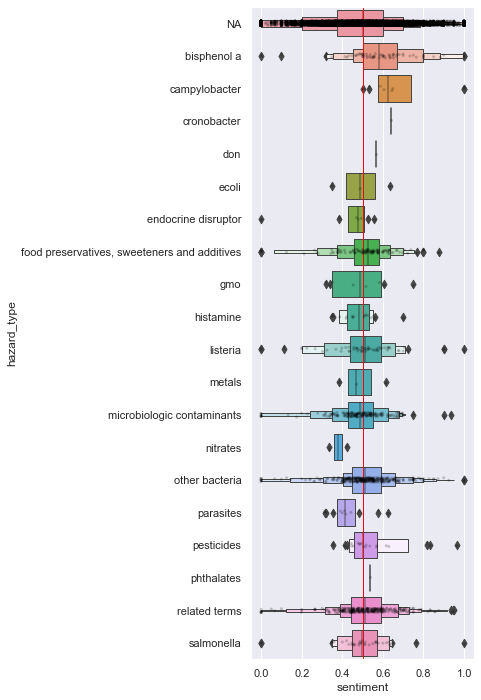

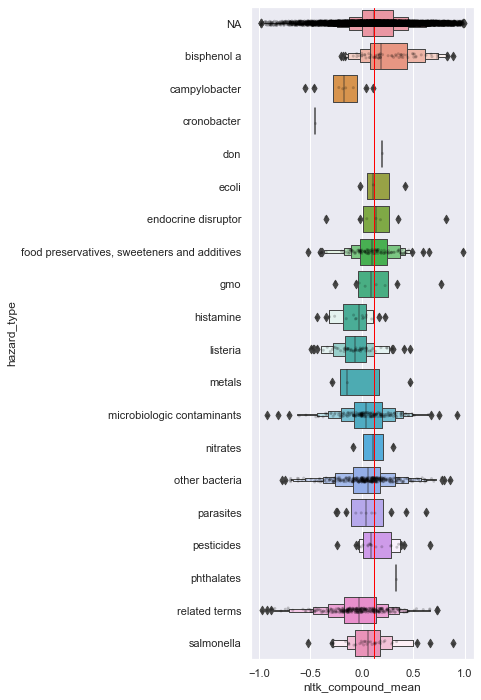

In [69]:
#sns.set(rc={'figure.figsize':(4,12)})
#sns.boxenplot(x='sentiment', y='hazard_type', data=class_df)
#plt.show()
#sns.boxenplot(x='nltk_compound_mean', y='hazard_type', data=class_df)
#plt.show()

sns.set(rc={'figure.figsize':(4,12)})
sns.boxenplot(x='sentiment', y='hazard_type', data=class_df, k_depth = 'trustworthy' ) #most are sizes are quite large so it doesnt hurt to use this.
sns.stripplot(x='sentiment', y='hazard_type', data=class_df, color='black', alpha=0.2, jitter=0.07, size=3) #to give an idea of the sample size
#vertical line at 50% quantile of NA, as a baseline
plt.axvline(np.quantile(class_df.loc[class_df['hazard_type'] == 'NA']['sentiment'],0.5), 0, c='red', linewidth=1)
plt.show()
sns.boxenplot(x='nltk_compound_mean', y='hazard_type', data=class_df, k_depth = 'trustworthy' ) #most are sizes are quite large so it doesnt hurt to use this.
sns.stripplot(x='nltk_compound_mean', y='hazard_type', data=class_df, color='black', alpha=0.2, jitter=0.07, size=3) #to give an idea of the sample size
#vertical line at 50% quantile of NA, as a baseline
plt.axvline(np.quantile(class_df.loc[class_df['hazard_type'] == 'NA']['nltk_compound_mean'].dropna(),0.5), 0, c='red', linewidth=1)
plt.show()

It may seem strange that these terms have positive sentiment. Keep in mind that we are looking at the sentiment in the entire post where the term occurs, and people are netmums are quite often very friendly to each other when replying.

#TODO: use only subset of terms around the phrases! (non-per  post approach probablY)

In [70]:
def boxstrip(x_name:str, y_name:str, df=class_df):
    """
    x some continuous or integer data, y some category which contains a cat 'NA'
    """
    sns.boxplot(x=x_name, y=y_name, data=df, fliersize=0, linewidth=1)
    #sns.boxenplot(x='subjectivity', y='hazard_type', data=class_df, k_depth='full', showfliers=False)
    sns.stripplot(x=x_name, y=y_name, data=df, color='black', alpha=0.8, jitter=0.07, size=3)
    #vertical line at 50% quantile of NA, as a baseline
    plt.axvline(np.quantile(class_df.loc[df[y_name] == 'NA'][x_name],0.5), 0, c='red', linewidth=1)

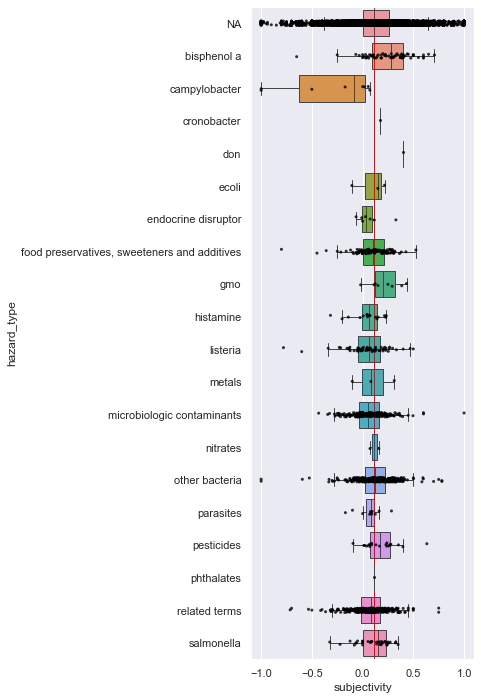

In [71]:
sns.set(rc={'figure.figsize':(4,12)})
boxstrip('subjectivity', 'hazard_type')


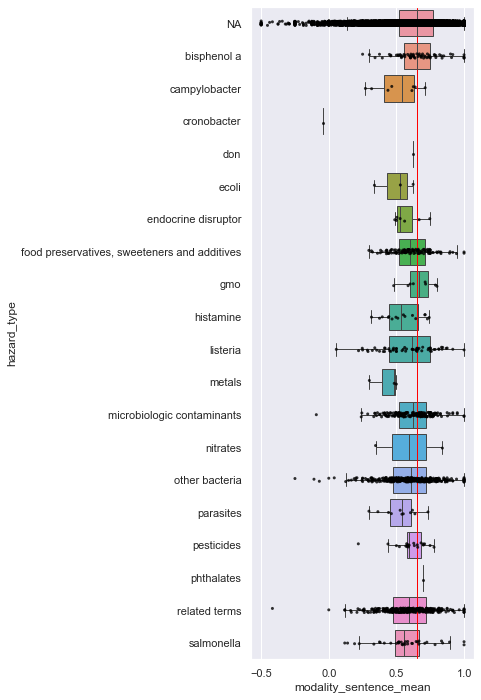

In [72]:
sns.set(rc={'figure.figsize':(4,12)})
boxstrip('modality_sentence_mean','hazard_type')

We can see that compared to posts without hazard terms (NA), posts with hazards mentioned tend to have lower confidence in what they are saying.

note: data for DON is extremely small. It is only one observation which by checking manually, I can confirm is not relevant (it is a typo of don't )
Cronobacter is also only one observation.

## Number of Occurences of Hazard Term by Category

Here, we examine the number of occurences in a post, with the goal of performing regressions between our metrics and the number of occurences in a post. Of course, if the number of occurences does not vary much then the regressions will be pointless

In [73]:
#assign the max to it's own col to graph easily
class_df['count_for_classified_hazard'] =class_df[hazards.keys()].max(axis=1)

<AxesSubplot:xlabel='count_for_classified_hazard', ylabel='hazard_type'>

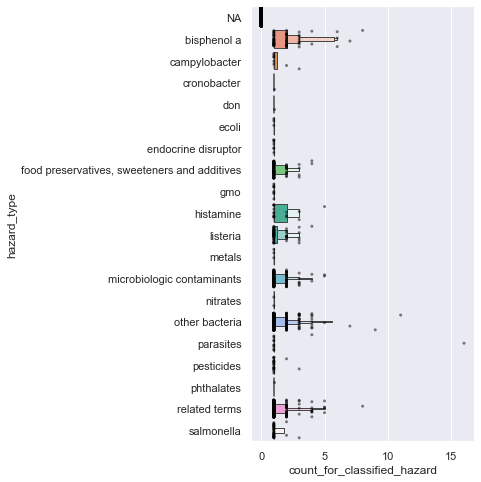

In [109]:
sns.set(rc={'figure.figsize':(4,8)})
sns.boxenplot(x='count_for_classified_hazard', y='hazard_type', data=class_df, k_depth='trustworthy', showfliers=False)
sns.stripplot(x='count_for_classified_hazard', y='hazard_type', data=class_df, color='black', alpha=0.5, jitter=0.4, size=3)

# Regression

In [75]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
#https://www.statsmodels.org/devel/index.html

In [76]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

In [77]:
X = np.array(class_df.loc[class_df['hazard_type'] != 'NA']['count_for_classified_hazard'])
y = class_df.loc[class_df['hazard_type'] != 'NA']['sentiment']

#skelarn implementation, I went with sm instead , its better.
#X of shape shape (n_samples, n_features)
#y of shape shape (n_samples,) or (n_samples, n_targets)
#reg = linear_model.LinearRegression().fit(X.reshape(-1,1), y)
#(reg.score(X.reshape(-1,1), y), reg.coef_ , reg.intercept_)

We get higher coefficient and lower intercept but obviosuly this is because the NA data has a 7000 subset of points with sentiment at zero.

# Interaction Modeled Regression: 
    * using hazard as category
    * using product as category
    
Regression Specification (todo):


$Y = \beta_0 + \bf{\beta} \mathbb{1}_{posthazrd category}\bf{X}$

So $\mathbb{1}$ is a factor variable splitting the counts of *all* hazards based on the hazard categroy determined

for this specification we do not need to drop NA because they are already separated and ran only by the factor vairable NA

In [221]:
X = class_df[list(hazards.keys()) + ['hazard_type', 'sentiment']]
X.columns = make_underscores(list(X.columns)) #for easy use with smf.
X.columns = [re.sub(',','',i) for i in X.columns] #for easy use with smf.

#https://www.statsmodels.org/stable/example_formulas.html#categorical-variables

regressors = list(X.columns.drop('hazard_type')) #this works because list.drop is not in place!
fmla = 'sentiment ~ (%s) : hazard_type' % ' + '.join(regressors)

results = smf.ols(formula=fmla, data=X, missing='drop').fit()
print(fmla)
print(results.summary())

sentiment ~ (chemical_contaminants + endocrine_disruptor + food_preservatives_sweeteners_and_additives + pesticides + veterinary_drugs + gmo + metals + mycotoxin + bisphenol_a + furan + don + dioxin_and_pcb + mosh_and_moah + nitrates + acrylamid + phthalates + microbiologic_contaminants + salmonella + campylobacter + listeria + ecoli + cronobacter + histamine + other_bacteria + virus + parasites + related_terms + sentiment) : hazard_type
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.542e+30
Date:                Sat, 17 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:28:51   Log-Likelihood:             6.4735e+05
No. Observations:               19671   AIC:                        -1.295e+06
Df Re

In [220]:
#the SAME THING buy by products!
X = class_df[list(hazards.keys()) + ['product_type', 'sentiment']]
X.columns = make_underscores(list(X.columns)) #for easy use with smf.
X.columns = [re.sub(',','',i) for i in X.columns] #for easy use with smf.

#https://www.statsmodels.org/stable/example_formulas.html#categorical-variables

regressors = list(X.columns.drop('product_type')) #this works because list.drop is not in place!
fmla = 'sentiment ~ (%s) : product_type' % ' + '.join(regressors)

results = smf.ols(formula=fmla, data=X, missing='drop').fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.391e+31
Date:                Sat, 17 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:28:45   Log-Likelihood:             6.5300e+05
No. Observations:               19671   AIC:                        -1.306e+06
Df Residuals:                   19591   BIC:                        -1.305e+06
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
                                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

# Simpler Models
* fewer coefficients & easier to interpret
* higher conf levels

In [81]:
#all hazard vars at once.
X = class_df.loc[class_df['hazard_type'] != 'NA'][hazards.keys()]
y = class_df.loc[class_df['hazard_type'] != 'NA']['sentiment']
X=sm.add_constant(X)
results = sm.OLS(y,X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.697
Date:                Fri, 16 Jul 2021   Prob (F-statistic):             0.0256
Time:                        23:18:26   Log-Likelihood:                 516.42
No. Observations:                1180   AIC:                            -988.8
Df Residuals:                    1158   BIC:                            -877.2
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [83]:
# TODO: ! There are multicollinearity problems possibly. How to fix? Why?

# NLTK Sentiment

In [102]:
#all hazard vars at once.
X = class_df.loc[class_df['hazard_type'] != 'NA'][hazards.keys()]
y = class_df.loc[class_df['hazard_type'] != 'NA']['nltk_compound_mean']
X=sm.add_constant(X)
results = sm.OLS(y,X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     nltk_compound_mean   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     5.126
Date:                Sat, 17 Jul 2021   Prob (F-statistic):           6.17e-13
Time:                        14:15:38   Log-Likelihood:                -87.598
No. Observations:                1180   AIC:                             219.2
Df Residuals:                    1158   BIC:                             330.8
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

We remove NA because these posts do not contain any mentions of hazards. They add unnecessary noise because their sentiments may vary due to other non-observed factors.

Significance at 5% level: 

* Positive: Bisphenol A, Pthalates
* Negative : Listeria, Cronobacter, Virus, Related Terms

# Subjectivity

In [104]:
X = class_df.loc[class_df['hazard_type'] != 'NA'][hazards.keys()]
y = class_df.loc[class_df['hazard_type'] != 'NA']['subjectivity']
X=sm.add_constant(X)
results = sm.OLS(y,X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           subjectivity   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     3.141
Date:                Sat, 17 Jul 2021   Prob (F-statistic):           2.45e-06
Time:                        14:24:23   Log-Likelihood:                 264.86
No. Observations:                1180   AIC:                            -485.7
Df Residuals:                    1158   BIC:                            -374.1
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------


Significance at 5% level: 

* Positive: Bisphenol A
* Negative : chemical contaminants, campylobacter, related terms

# Modality (how sure the person sounds)

In [105]:
X = class_df.loc[class_df['hazard_type'] != 'NA'][hazards.keys()]
y = class_df.loc[class_df['hazard_type'] != 'NA']['modality_sentence_mean']
X=sm.add_constant(X)
results = sm.OLS(y,X).fit()
print(results.summary())

                              OLS Regression Results                              
Dep. Variable:     modality_sentence_mean   R-squared:                       0.031
Model:                                OLS   Adj. R-squared:                  0.013
Method:                     Least Squares   F-statistic:                     1.767
Date:                    Sat, 17 Jul 2021   Prob (F-statistic):             0.0176
Time:                            14:24:36   Log-Likelihood:                 376.73
No. Observations:                    1180   AIC:                            -709.5
Df Residuals:                        1158   BIC:                            -597.9
Df Model:                              21                                         
Covariance Type:                nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------


Significance at 5% level: 

* Positive: mycotoxin, bisphenol a, mosh and moah, acrylamid, microbiologic contaminants
* Negative : chemical contaminants, cronobacter